In [1]:
import numpy as np
import scipy

import matplotlib.pyplot as plt
import matplotlib as mpl

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

In [2]:
# Constants and general functions

h = 6.62607015E-34 # J⋅Hz−1, Plank's constant
hbar = h/(2*np.pi)
Hartrees_to_Joules = 4.3597447222060E-18

## Finite difference numerical derivatives
dfdx = lambda f, x, Δ = 1E-7: (f(x + Δ) - f(x - Δ))/(2*Δ)
d2fdx2 = lambda f, x, Δ = 1E-7: (f(x + Δ) - 2*f(x) + f(x - Δ))/(Δ*Δ)

def matrix_elements(Ψ_b, Ahat, xmin, xmax):
  """ Numerical integration in 1D to calculate matrix elements for a set of basis wavefunctions

  Parameters
  ----------
  Ψ_b: list of functions
    Basis wavefunctions.
  Ahat: function,
    Operator. Use `lambda f, x:f(x)` for overlap integral.
  xmin: float
    Minumum of integration range
  xmax: float
    Maximum of integration range

  Returns
  -------
  np.array
    Matrix elements of the Ahat operator
  """
  nfunctions = len(Ψ_b)
  A = np.zeros((nfunctions,nfunctions))
  for n in range(nfunctions):
    for m in range(n, nfunctions):
      A[n,m] = scipy.integrate.quad(lambda x:Ψ_b[n](x)*Ahat(Ψ_b[m],x), \
                                    xmin, xmax, full_output=True)[0]
      if n!=m:
        A[m,n] = A[n,m]
  return A

# Perturbation Theory Approximation of Perturbed Particle in a Box

In [3]:
L = 1E-9 # m, Length of the box
m = 9.1093837E-31 # kg, Mass of an electron

# Ground state basis functions and energies
Ψ_b = [lambda x: np.sqrt(2/L)*np.sin(1*np.pi*x/L), \
       lambda x: np.sqrt(2/L)*np.sin(2*np.pi*x/L), \
       lambda x: np.sqrt(2/L)*np.sin(3*np.pi*x/L), \
       lambda x: np.sqrt(2/L)*np.sin(4*np.pi*x/L), \
       lambda x: np.sqrt(2/L)*np.sin(5*np.pi*x/L), \
       lambda x: np.sqrt(2/L)*np.sin(6*np.pi*x/L), \
       lambda x: np.sqrt(2/L)*np.sin(7*np.pi*x/L), \
       lambda x: np.sqrt(2/L)*np.sin(8*np.pi*x/L)]
E_k = np.array([1,2,3,4,5,6,7,8])**2*np.square(h)/(8*m*np.square(L))

## Potential energy step function within the a box

In [4]:
def render(ε = 0.25, a = 0.1, mid = 0.5):
  """Computes and displays perturbed wavefunction for a step in the middle of a box

  Parameters
  ----------
  ε: float
    Hartrees, size of step in the potential energy
  a: float
    width of step, as a fraction of the box
  mid: float
    center of the step, as a fraction of box
  """
  ε_J = ε*Hartrees_to_Joules # Convert to Joules

  # This is a step in the middle of the box
  H1 = lambda f, x: ε_J*(np.abs(x - mid*L) < a*L/2.)*f(x)

  H = matrix_elements(Ψ_b, H1, 0, L)
  c_k = H[1:,0]/(E_k[0] - E_k[1:])
  c_k = [1.] + list(c_k)

  x = np.linspace(0,L,100)

  plt.figure(figsize=(12,3))

  plt.subplot(1,3,1)
  plt.title('Perturbation (Hartrees)')
  plt.plot(x, H1(lambda x:1, x)/Hartrees_to_Joules)
  plt.xlabel('Position');

  plt.subplot(1,3,2)
  plt.title('Wavefunction')
  for i in range(len(c_k)):
    plt.plot(x, c_k[i]*Ψ_b[i](x),'--')
  plt.plot(x, np.sum([c_k[i]*Ψ_b[i](x) for i in range(len(c_k))],0),'-k')
  plt.yticks([])
  plt.xlabel('Position');

  plt.subplot(1,3,3)
  plt.title('Probability')
  plt.plot(x, np.square(np.sum([c_k[i]*Ψ_b[i](x) for i in range(len(c_k))],0)),'-k')
  plt.xlabel('Position');
  plt.show()

  print('Energies (Hartrees): ', ', '.join([f'{x:.3e}' for x in E_k/Hartrees_to_Joules]))
  print('Hamiltonian matrix elements (Hartrees):')
  print('\n'.join([', '.join([f'{val:+.3e}' for val in row]) for row in H/Hartrees_to_Joules]))
  print('Coefficients       : ', ', '.join([f'{x:.7f}' for x in c_k]))
  Ep = (E_k[0] + H[0,0])/Hartrees_to_Joules
  print(f'Perturbed energy   : {Ep:0.3e} Hartrees')

interactive(render, \
  ε = widgets.FloatSlider(min=-1, max=1, value=0.25,\
                          description='Height (Hartrees)'), \
  a = widgets.FloatSlider(min=0., max=1, value=0.1, \
                          description='Width (as fraction of box)'), \
  mid = widgets.FloatSlider(min=0., max=1., value=0.5,\
                          description="Center (as fraction of box)"))

interactive(children=(FloatSlider(value=0.25, description='Height (Hartrees)', max=1.0, min=-1.0), FloatSlider…

Start with the default settings (ε = 0.25 Hartrees; a = 0.1; mid = 0.5).

--> What happens to the probability density as you increase the height of the barrier? What if you make it negative (a well)?

--> Are there coefficients that are zero? Why?

Now move the center of the perturbation to the right?

--> How are the coefficient affected?

--> How is the probability affected?

## Sinusoial perturbation

In [5]:
def render(ε = 0.25, n = 1):
  """Computes and displays perturbed wavefunction for a sinusoial perturbation

  Parameters
  ----------
  ε: float
    Hartrees, scaling factor for the sinusoidal perturbation
  n: int
    the number of half period
  """
  ε_J = ε*Hartrees_to_Joules # Convert to Joules

  # This is a step in the middle of the box
  H1 = lambda f, x: ε_J*(np.sin(n*np.pi*x/L))*f(x)

  H = matrix_elements(Ψ_b, H1, 0, L)
  c_k = H[1:,0]/(E_k[0] - E_k[1:])
  c_k = [1.] + list(c_k)

  x = np.linspace(0,L,100)

  plt.figure(figsize=(12,3))

  plt.subplot(1,3,1)
  plt.title('Perturbation (Hartrees)')
  plt.plot(x, H1(lambda x:1, x)/Hartrees_to_Joules)
  plt.xlabel('Position');

  plt.subplot(1,3,2)
  plt.title('Wavefunction')
  for i in range(len(c_k)):
    plt.plot(x, c_k[i]*Ψ_b[i](x),'--')
  plt.plot(x, np.sum([c_k[i]*Ψ_b[i](x) for i in range(len(c_k))],0),'-k')
  plt.yticks([])
  plt.xlabel('Position');

  plt.subplot(1,3,3)
  plt.title('Probability')
  plt.plot(x, np.square(np.sum([c_k[i]*Ψ_b[i](x) for i in range(len(c_k))],0)),'-k')
  plt.xlabel('Position');
  plt.show()

  print('Energies (Hartrees): ', ', '.join([f'{x:.3e}' for x in E_k/Hartrees_to_Joules]))
  print('Hamiltonian matrix elements (Hartrees):')
  print('\n'.join([', '.join([f'{val:+.3e}' for val in row]) for row in H/Hartrees_to_Joules]))
  print('Coefficients       : ', ', '.join([f'{x:.7f}' for x in c_k]))
  Ep = (E_k[0] + H[0,0])/Hartrees_to_Joules
  print(f'Perturbed energy   : {Ep:0.3e} Hartrees')

interactive(render, \
  ε = widgets.FloatSlider(min=-1, max=1, value=0.25,\
                          description='Height (Hartrees)'), \
  n = widgets.IntSlider(min=0, max=10, value=1, \
                          description='Half periods'))

interactive(children=(FloatSlider(value=0.25, description='Height (Hartrees)', max=1.0, min=-1.0), IntSlider(v…

Start with the default settings (ε = 0.25 Hartrees; n = 1).

--> What happens to the probability density as you increase the height of the barrier? What if you make it negative (a well)?

--> Are there coefficients that are zero? Why?

Now increase the number of half periods.

--> How are the coefficients affected?

--> How is the probability affected?

# Perturbation Theory Approximation of Perturbed Harmonic Oscillator

In [6]:
# Constants
k_f = 313.8 # N.m^{-1}, Spring constant

α = (m*k_f/np.square(hbar))**(1/4.)
α2 = α*α
ω = np.sqrt(k_f/m)
L = 0.75E-9 # m, Limit of integration

In [7]:
# Ground state basis functions and energies
import math
N_ν = lambda ν: np.sqrt(α/(2**ν*math.factorial(ν)*np.sqrt(np.pi)))
Ψ_b = [lambda x: N_ν(0)*np.polynomial.hermite.Hermite((1.))(α*x)*np.exp(-α2*x*x/2), \
       lambda x: N_ν(1)*np.polynomial.hermite.Hermite((0,1.))(α*x)*np.exp(-α2*x*x/2), \
       lambda x: N_ν(2)*np.polynomial.hermite.Hermite((0,0,1.))(α*x)*np.exp(-α2*x*x/2), \
       lambda x: N_ν(3)*np.polynomial.hermite.Hermite((0,0,0,1.))(α*x)*np.exp(-α2*x*x/2), \
       lambda x: N_ν(4)*np.polynomial.hermite.Hermite((0,0,0,0,1.))(α*x)*np.exp(-α2*x*x/2), \
       lambda x: N_ν(5)*np.polynomial.hermite.Hermite((0,0,0,0,0,1.))(α*x)*np.exp(-α2*x*x/2)]
E_k = (np.array([0,1,2,3,4,5])+0.5)*hbar*ω

## Potential energy step function

In [8]:
def render(ε = 0.25, a = 0.1, mid = 0.5):
  """Computes and displays perturbed wavefunction for a step in the middle of a integration range

  Parameters
  ----------
  ε: float
    Hartrees, size of step in the potential energy
  a: float
    width of step, as a fraction of the integration range
  mid: float
    center of the step, as a fraction of integration range
  """
  ε_J = ε*Hartrees_to_Joules # Convert to Joules

  # This is a step in the middle of the range
  H1 = lambda f, x: ε_J*(np.abs(x - mid*L) < a*L)*f(x)

  H = matrix_elements(Ψ_b, H1, -L, L)
  c_k = H[1:,0]/(E_k[0] - E_k[1:])
  c_k = [1.] + list(c_k)

  x = np.linspace(-L,L,100)

  plt.figure(figsize=(12,3))

  plt.subplot(1,3,1)
  plt.title('Perturbation (Hartrees)')
  plt.plot(x, H1(lambda x:1, x)/Hartrees_to_Joules)
  plt.xlabel('Position');

  plt.subplot(1,3,2)
  plt.title('Wavefunction')
  for i in range(len(c_k)):
    plt.plot(x, c_k[i]*Ψ_b[i](x),'--')
  plt.plot(x, np.sum([c_k[i]*Ψ_b[i](x) for i in range(len(c_k))],0),'-k')
  plt.yticks([])
  plt.xlabel('Position');

  plt.subplot(1,3,3)
  plt.title('Probability')
  plt.plot(x, np.square(np.sum([c_k[i]*Ψ_b[i](x) for i in range(len(c_k))],0)),'-k')
  plt.xlabel('Position');
  plt.show()

  print('Energies (Hartrees): ', ', '.join([f'{x:.3e}' for x in E_k/Hartrees_to_Joules]))
  print('Hamiltonian matrix elements (Hartrees):')
  print('\n'.join([', '.join([f'{val:+.3e}' for val in row]) for row in H/Hartrees_to_Joules]))
  print('Coefficients       : ', ', '.join([f'{x:.7f}' for x in c_k]))
  Ep = (E_k[0] + H[0,0])/Hartrees_to_Joules
  print(f'Perturbed energy   : {Ep:0.3e} Hartrees')

interactive(render, \
  ε = widgets.FloatSlider(min=-10, max=10, value=2.,\
                          description='Height (Hartrees)'), \
  a = widgets.FloatSlider(min=0., max=1, value=0.1, \
                          description='Width (as fraction of range)'), \
  mid = widgets.FloatSlider(min=-1., max=1., value=0,\
                          description="Center (as fraction of range)"))

interactive(children=(FloatSlider(value=2.0, description='Height (Hartrees)', max=10.0, min=-10.0), FloatSlide…

Start with the default settings (ε = 2 Hartrees; Width = 0.1; Center = 0).

--> How does the probability density compare to when there is no perturbation?

--> Are there coefficients that are zero? Why?

--> How can you shift the probability density to the right?

# Variation Theory Approximation of a Hydrogenic Atom

In [9]:
ε_0 = 8.8541878188 # F.m^{-1}, Permittivity of free space
e = 1.602176E-19 # C, Elementary charge
m = 1.674927E-27 # kg, Mass of neutron
a = e*e*m/(2*np.pi*ε_0*hbar*hbar) # m, radius

# Wavefunctions
Ψ_g = lambda r: np.exp(-a*r/2)
Ψ_t = lambda r, α: np.exp(-α*r)
# Ψ_t = lambda r, α: np.exp(-α*r*r)

α = 1
R = 0.1
r = np.linspace(0,R,100)

Hhat = lambda f, r: -hbar*hbar/(2*m*r)*d2fdx2(lambda r:r*f(r), r) - \
  e**2/(4*np.pi*ε_0*r)*f(r)

S_g = scipy.integrate.quad(lambda r:Ψ_g(r)*Ψ_g(r)*np.square(r), 0, 3*R)[0]
H_g = scipy.integrate.quad(lambda r:Ψ_g(r)*Hhat(Ψ_g, r)*np.square(r), 0, 3*R)[0]
E_g = H_g/S_g

def render(α):
  S_t = scipy.integrate.quad(lambda r:Ψ_t(r, α)*Ψ_t(r, α)*np.square(r), 0, 3*R)[0]
  H_t = scipy.integrate.quad(lambda r:Ψ_t(r, α)*Hhat(lambda r: Ψ_t(r, α), r)*np.square(r), 0, 3*R)[0]
  E_t = H_t/S_t

  plt.figure(1)
  plt.plot(r, Ψ_g(r)/np.sqrt(S_g))
  plt.plot(r, Ψ_t(r, α)/np.sqrt(S_t))
  plt.legend(['Ground state', 'Ψ$_t$'])
  plt.show()

  print(f'Ground state energy:       {E_g:0.5e}')
  print(f'Trial wavefunction energy: {E_t:0.5e}')

interactive(render, α=(10., 100.))
# interactive(render, α=(100., 500.))

interactive(children=(FloatSlider(value=300.0, description='α', max=500.0, min=100.0), Output()), _dom_classes…

--> For the trial wavefunction `Ψ_t = lambda r, α: np.exp(-α*r)`, about what value of `α` is the energy the lowest?

--> Modify the code to use the trial wavefunction `Ψ_t = lambda r, α: np.exp(-α*r*r)`. Try varying α from 100 to 500. About what value of `α` is the energy the lowest?

# Rayleigh-Ritz Approximation to a Particle in a Box

We will approximate the ground state of a particle in a box using a test wavefunction that is the linear combination of two arbitrary functions.

In [10]:
# This pertains to the true solution

# Constants
# n = 1
# hbar = 1.05457160E-34 # J.s
# m = 9.10938E-31 kg, for an electron
# E_o = n**2*np.pi**2*hbar**2/(2*m*L**2)
L = 1 # m

Ψ_g = lambda x: np.sqrt(2/L)*np.sin(np.pi*x/L)
E_o = np.pi**2/2

The functions are defined and matrix elements computed here

In [11]:
# Basis wavefunctions
Ψ_b = [lambda x: x*(1-x), lambda x: x**2*(1-x)**2]

# Here are some basis functions that can be tried
# Ψ_b[0] = lambda x: x*(1-x)
# Ψ_b[1] = lambda x: x**2*(1-x)**2
# Ψ_b[0] = lambda x: x*(1-x)*np.exp(-x)
# Ψ_b[1] = lambda x: x**2*(1-x)**2*np.exp(x)

# Matrix elements
## Overlap integrals
S = matrix_elements(Ψ_b, lambda f, x:f(x), 0, L)
print(f'S = \t{S[0,0]:.5f}\t{S[0,1]:.5f}\n \t{S[1,0]:.5f}\t{S[1,1]:.5f}\n')

## Hamiltonian
Hhat = lambda f, x: -d2fdx2(f, x)/2
H = matrix_elements(Ψ_b, Hhat, 0, L)
print(f'H = \t{H[0,0]:.5f}\t{H[0,1]:.5f}\n \t{H[0,1]:.5f}\t{H[1,1]:.5f}')

S = 	0.03333	0.00714
 	0.00714	0.00159

H = 	0.16666	0.03333
 	0.03333	0.00952


Here we can manually adjust the coefficient that the wavefunctions are multiplied by.

In [12]:
x = np.linspace(0,L,100)

def render(c_1):
  # Solve for c_2 that normalizes the wavefunction
  # S[1,1]*c_2*c_2 + 2*c_1*S[0,1]*c_2 + (c_1*c_1*S[0,0] - 1) = 0
  a = S[1,1]
  b = 2*c_1*S[0,1]
  c = (c_1*c_1*S[0,0] - 1)
  c_2 = (-b + np.sqrt(np.square(b) - 4*a*c))/(2*a)

  E = c_1*c_1*H[0,0] + 2*c_1*c_2*H[0,1] + c_2*c_2*H[1,1]

  plt.figure(1)
  plt.plot(x, Ψ_g(x))
  plt.plot(x, c_1*Ψ_b[0](x),'--')
  plt.plot(x, c_2*Ψ_b[1](x),'--')
  plt.plot(x, (c_1*Ψ_b[0](x) + c_2*Ψ_b[1](x)))
  plt.legend(['Ground state', 'c$_1$*Ψ$_1$', 'c$_2$*Ψ$_2$', 'Ψ$_t$'])
  plt.show()

  print(f'c_2: \t{c_2:.3f}')
  print(f'E: \t{E:.5f} hbar**2/m')
  print(f'E_o: \t{E_o:.5f} hbar**2/m')

interactive(render, c_1=(0., np.sqrt(1/S[0,0])))

interactive(children=(FloatSlider(value=2.7386127875258306, description='c_1', max=5.477225575051661), Output(…

The code below finds and plots the optimal solution.

E_o: 4.93480 hbar**2/m
Optimal E: 4.93450 hbar**2/m
Optimal c_1: 4.40227; c_2: 4.99835


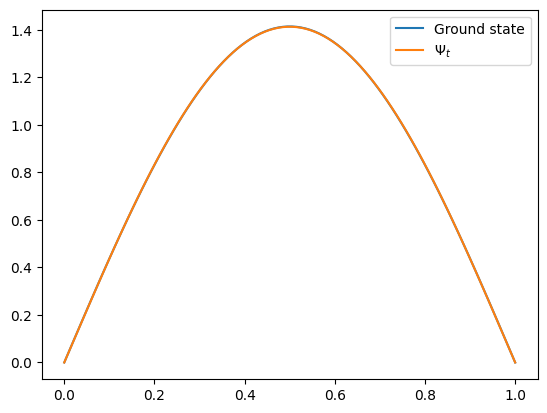

In [13]:
# det|H - ES|
# = (H[0,0] - E*S[0,0])(H[1,1] - E*S[1,1]) - (H[0,1] - E*S[0,1])**2
#   H[0,0]*H[1,1] - (H[1,1]*S[0,0] + H[0,0]*S[1,1])*E + S[0,1]*S[1,1]*E**2
# -(H[0,1]**2   - 2*H[0,1]*S[0,1]*E             + S[0,1]*S[0,1]*E**2)
a = S[0,0]*S[1,1] - S[0,1]*S[0,1]
b = -H[1,1]*S[0,0] - H[0,0]*S[1,1] + 2*H[0,1]*S[0,1]
c = H[0,0]*H[1,1] - H[0,1]*H[0,1]
E = (-b - np.sqrt(np.square(b) - 4*a*c))/(2*a)
c2_over_c1 = -(H[0,0] - E*S[0,0])/(H[0,1] - E*S[0,1])
c_1 = 1/np.sqrt((S[1,1]*c2_over_c1*c2_over_c1 + 2*S[0,1]*c2_over_c1 + S[0,0]))
c_2 = c2_over_c1*c_1

print(f'E_o: {E_o:.5f} hbar**2/m')
print(f'Optimal E: {E:0.5f} hbar**2/m')
print(f'Optimal c_1: {c_1:0.5f}; c_2: {c_2:0.5f}')

plt.plot(x, Ψ_g(x))
plt.plot(x, (c_1*Ψ_b[0](x) + c_2*Ψ_b[1](x)))
plt.legend(['Ground state', 'Ψ$_t$']);

--> Replace the basis functions with these below:

`Ψ_b = [lambda x: x**2*(1-x), lambda x: x*(1-x)**2]`

What are the optimal energy and coefficients?

--> Try another pair of basis wavefunctions and add your code below. What are the optimal energy and coefficients? Remember that your functions should satisfy the boundary conditions (0 at x = 0 and x = 1).